## Download the dataset

In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete8WTFQF/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete8WTFQF/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete8WTFQF/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Prepare the dataset

In [2]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

In [16]:
# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

## Build and compile the model

### 1. Single Layer LSTM

In [17]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm_dim = 64
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 33s 274ms/step - loss: 0.6047 - accuracy: 0.6587 - val_loss: 0.5885 - val_accuracy: 0.6855
Epoch 2/10
98/98 [==============================] - 25s 252ms/step - loss: 0.3826 - accuracy: 0.8376 - val_loss: 0.4366 - val_accuracy: 0.8087
Epoch 3/10
98/98 [==============================] - 24s 248ms/step - loss: 0.2796 - accuracy: 0.8957 - val_loss: 0.4230 - val_accuracy: 0.8322
Epoch 4/10
98/98 [==============================] - 34s 347ms/step - loss: 0.2999 - accuracy: 0.8807 - val_loss: 0.4452 - val_accuracy: 0.8114
Epoch 5/10
98/98 [==============================] - 27s 271ms/step - loss: 0.2639 - accuracy: 0.9032 - val_loss: 0.4504 - val_accuracy: 0.8155
Epoch 6/10
98/98 [==============================] - 26s 261ms/step - loss: 0.2105 - accuracy: 0.9265 - val_loss: 0.4509 - val_accuracy: 0.8265
Epoch 7/10
98/98 [==============================] - 25s 255ms/step - loss: 0.1656 - accuracy: 0.9436 - val_loss: 0.4851 - val_accuracy: 0.8339

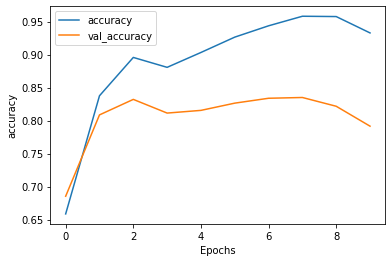

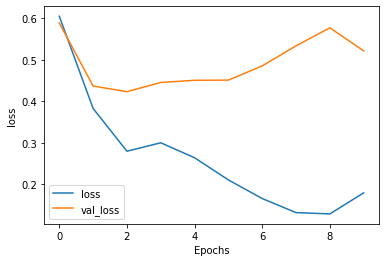

In [20]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### 2. Multiple LSTMs

In [22]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True ): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True ): (1, 20, 8)


In [23]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-tr

In [24]:
# Set the training parameters
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
# Train the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 57s 534ms/step - loss: 0.5809 - accuracy: 0.6732 - val_loss: 0.5624 - val_accuracy: 0.7572
Epoch 2/10
98/98 [==============================] - 45s 462ms/step - loss: 0.4085 - accuracy: 0.8290 - val_loss: 0.4596 - val_accuracy: 0.7996
Epoch 3/10
98/98 [==============================] - 48s 493ms/step - loss: 0.2835 - accuracy: 0.8888 - val_loss: 0.4057 - val_accuracy: 0.8106
Epoch 4/10
98/98 [==============================] - 45s 459ms/step - loss: 0.2494 - accuracy: 0.9058 - val_loss: 0.4026 - val_accuracy: 0.8234
Epoch 5/10
98/98 [==============================] - 52s 534ms/step - loss: 0.2006 - accuracy: 0.9280 - val_loss: 0.4184 - val_accuracy: 0.8462
Epoch 6/10
98/98 [==============================] - 45s 459ms/step - loss: 0.1393 - accuracy: 0.9544 - val_loss: 0.4688 - val_accuracy: 0.8359
Epoch 7/10
98/98 [==============================] - 45s 455ms/step - loss: 0.1169 - accuracy: 0.9626 - val_loss: 0.4854 - val_accuracy: 0.8329

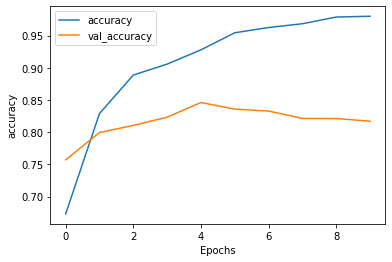

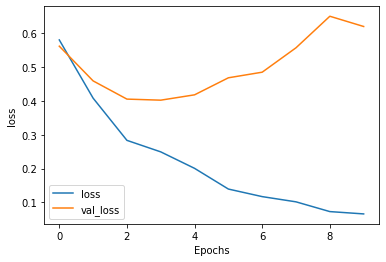

In [26]:
# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### 3. Using CNN Conv1D

In [27]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 20
filters = 128
kernel_size = 5

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'filters: {filters}')
print(f'kernel_size: {kernel_size}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)
shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


In [28]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
filters = 128
kernel_size = 5
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          523840    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
________________________________________________

In [30]:
# Set the training parameters
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
# Train the model
history = model.fit(train_dataset,
                    epochs= 10,
                    validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 46s 442ms/step - loss: 0.6093 - accuracy: 0.6776 - val_loss: 0.4030 - val_accuracy: 0.8231
Epoch 2/10
98/98 [==============================] - 19s 194ms/step - loss: 0.2951 - accuracy: 0.8770 - val_loss: 0.2740 - val_accuracy: 0.8856
Epoch 3/10
98/98 [==============================] - 14s 144ms/step - loss: 0.1574 - accuracy: 0.9452 - val_loss: 0.2716 - val_accuracy: 0.8875
Epoch 4/10
98/98 [==============================] - 12s 119ms/step - loss: 0.0761 - accuracy: 0.9796 - val_loss: 0.2887 - val_accuracy: 0.8910
Epoch 5/10
98/98 [==============================] - 13s 129ms/step - loss: 0.0260 - accuracy: 0.9969 - val_loss: 0.3238 - val_accuracy: 0.8914
Epoch 6/10
98/98 [==============================] - 11s 108ms/step - loss: 0.0086 - accuracy: 0.9997 - val_loss: 0.3608 - val_accuracy: 0.8897
Epoch 7/10
98/98 [==============================] - 11s 105ms/step - loss: 0.0039 - accuracy: 0.9999 - val_loss: 0.3824 - val_accuracy: 0.8904

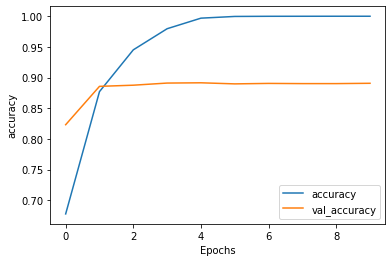

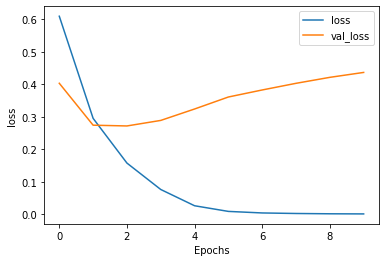

In [32]:
# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")